In [1]:
from lalpulsar.piecewise_model.pw_model_simulations import waveform
%load_ext autoreload
%autoreload 2

/home/avaj040/Documents/venvs/starccato_jax/lib/python3.11/site-packages/lalpulsar/lalpulsar.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


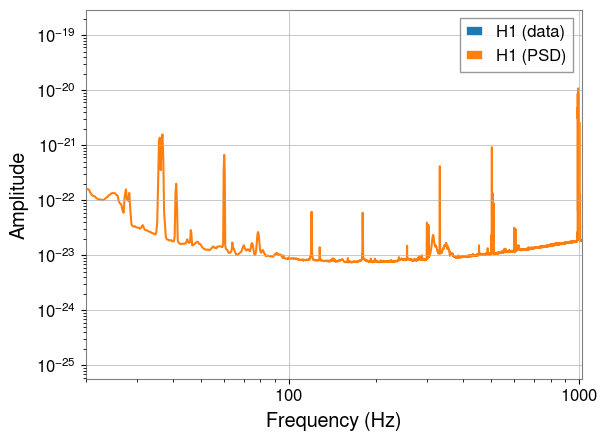

In [32]:
import jax
from starccato_lvk.detector import H1, L1
from  starccato_lvk.data import Data, PowerSpectrum
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax.random import PRNGKey

rng = PRNGKey(42)

jax.config.update("jax_enable_x64", True)



# first, fetch a 4s segment centered on GW150914
gps = 1126259462.4
start = gps - 2
end = gps + 2
duration = 4
post_trigger_duration = 2
start_pad = duration - post_trigger_duration
end_pad = post_trigger_duration
fmin = 20.0
fmax = 1024.0

psd_start = gps - 2048
psd_end = gps + 2048

ifos = [H1] #, L1] JUST H1 for now to make faster

# for ifo in ifos:
#     psd = PowerSpectrum.from_asd(ifo.name)
#     data = psd.simulate_data(rng)
#     ifo.set_psd(psd)
#     ifo.set_data(data)  
    

for ifo in ifos:
    # set analysis data
    data = Data.from_gwosc(ifo.name, start, end)
    ifo.set_data(data)

    # set PSD (Welch estimate)
    psd_data = Data.from_gwosc(ifo.name, psd_start, psd_end)
    psd_fftlength = data.duration * data.sampling_frequency
    ifo.set_psd(psd_data.to_psd(nperseg=psd_fftlength))

plt.figure()
for detector in ifos:  # type: ignore
    plt.loglog(
        detector.data.frequencies,
        jnp.abs(detector.data.fd),
        label=detector.name + " (data)",
        zorder=10,
        
    )
    plt.loglog(
        detector.psd.frequencies,
        jnp.sqrt(jnp.abs(detector.psd.values)),
        label=detector.name + " (PSD)",

    )
plt.xlim(fmin, fmax)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()

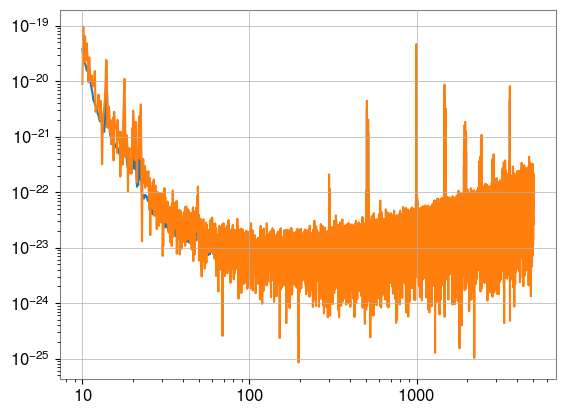

In [34]:
import numpy as np

true_psd = np.loadtxt("https://dcc.ligo.org/public/0169/P2000251/001/O3-H1-C01_CLEAN_SUB60HZ-1251752040.0_sensitivity_strain_asd.txt")
psd, freq = true_psd[:, 1]**2, true_psd[:, 0]
delta_f = freq[1] - freq[0]
key, subkey = jax.random.split(rng, 2)
var = psd / (4 * delta_f)
noise_real = jax.random.normal(key, shape=var.shape) * np.sqrt(var)
noise_imag = jax.random.normal(subkey, shape=var.shape) * np.sqrt(var)
fd = (noise_real + 1j * noise_imag) 


# Inverse FFT to get the real time series
td = jnp.fft.ifft(fd, axis=-1).real



plt.loglog(freq, jnp.sqrt(jnp.abs(psd)),)
plt.loglog(freq, jnp.abs(fd))

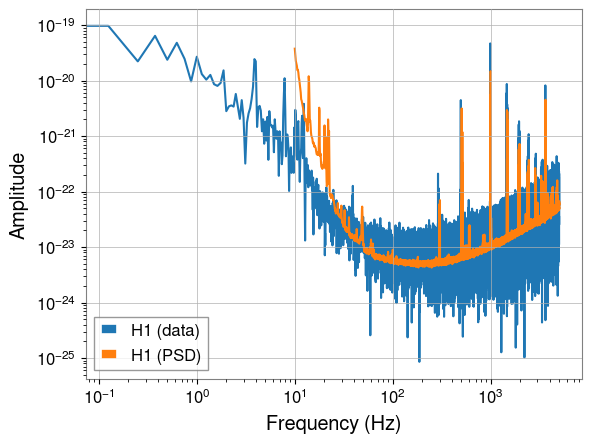

In [48]:
ifos2 = [H1]


for ifo in ifos:
    # set analysis data
    ifo.psd = PowerSpectrum.from_asd(ifo.name)
    data = ifo.psd.simulate_data(rng)
    ifo.set_data(data)
    
    
plt.figure()
for detector in ifos2:  # type: ignore
    plt.loglog(
        detector.data.frequencies,
        jnp.abs(detector.data.fd),
        label=detector.name + " (data)",
        zorder=-10,
        
        
    )
    plt.loglog(
        detector.psd.frequencies,
        jnp.sqrt(jnp.abs(detector.psd.values)),
        label=detector.name + " (PSD)",

    )
# plt.xlim(fmin, fmax)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()

In [45]:
ifos2[0].data.fd

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
psd.simulate_data(rng).td

array([-3.42293738e-14, -4.09432665e-14, -1.97978127e-14, ...,
       -5.00311857e-14, -6.34947771e-14,  5.07639476e-14])

In [11]:
detector.data.fd

array([0., 0., 0., ..., 0., 0., 0.])

In [5]:
from starccato_lvk.waveform import StarccatoWaveform
from jax.random import PRNGKey

rng = PRNGKey(42)


waveform = StarccatoWaveform(rng)

In [7]:
from starccato_lvk.prior import  UniformPrior, CosinePrior,  PowerLawPrior, CombinePrior, StandardNormalDistribution
import jax.numpy as jnp



# latent-vector prior
z_prior = [
    StandardNormalDistribution(parameter_names=[f"z_{i}"]) for i in range(waveform.vae.latent_dim)
]

# Extrinsic prior
dL_prior = PowerLawPrior(1.0, 2000.0, 2.0, parameter_names=["d_L"])
t_c_prior = UniformPrior(-0.05, 0.05, parameter_names=["t_c"])
phase_c_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"])
psi_prior = UniformPrior(0.0, jnp.pi, parameter_names=["psi"])
ra_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"])
dec_prior = CosinePrior(parameter_names=["dec"])
prior = z_prior + [
    dL_prior,
    t_c_prior,
    phase_c_prior,
    psi_prior,
    ra_prior,
    dec_prior,
]
prior = CombinePrior(prior)


In [17]:
from starccato_lvk.likelihood import TransientLikelihoodFD

likelihood = TransientLikelihoodFD(
    ifos, 
    waveform=waveform, 
    f_min=fmin, 
    f_max=fmax, 
    trigger_time=gps,
)

s = prior.sample(rng, 1)
data = [ifo.data for ifo in ifos]
likelihood.evaluate(s)

TypeError: TransientLikelihoodFD.evaluate() missing 1 required positional argument: 'data'